In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from torch.autograd import Variable
from skimage.util import random_noise
from google.colab.patches import cv2_imshow


In [31]:
class DnCNN(nn.Module):
    def __init__(self):
        super(DnCNN, self).__init__()
        # in layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(18):
          hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
          hidden_layers.append(nn.BatchNorm2d(64))
          hidden_layers.append(nn.ReLU(inplace=True))
        self.mid_layer = nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.mid_layer(out)
        out = self.conv3(out)
        return out
        

In [32]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".gif"])

In [33]:
class ImageDataset(Dataset):
  def __init__(self, image_dir, input_transforms=None):
      super(ImageDataset, self).__init__()
      self.image_filenames = [os.path.join(image_dir, x) for x in os.listdir(image_dir) if is_image_file(x)]
      self.input_transforms = input_transforms

  def __getitem__(self, index):
      input = Image.open(self.image_filenames[index])

      if self.input_transforms:
        input = self.input_transforms(input)
      
      return input
  
  def __len__(self):
      return len(self.image_filenames)

In [34]:
def input_transforms(crop_size):
  return transforms.Compose([
                             transforms.Resize((crop_size, crop_size)),
                             transforms.ToTensor(),
  ])

In [35]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
train_dir = '/content/drive/My Drive/SR_Data/train/hr'
test_dir =  '/content/drive/My Drive/SR_Data/test/hr'

In [37]:
crop_size = 128

In [38]:
train_dataset = ImageDataset(train_dir, input_transforms(crop_size))
test_dataset = ImageDataset(test_dir, input_transforms(crop_size))

In [39]:
batch_size = 128

In [40]:
training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [41]:
model = DnCNN().to(device)
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr)

In [42]:
def gaussian(ins, is_training, mean, stddev):  
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise, noise

In [43]:
def train(epoch):
    epoch_loss = 0
    for iteration, data in enumerate(training_data_loader, 1)

        target = data
        input, noise = gaussian(target, 0, 0.05)
        
        input = Variable(input.cuda())
        noise = Variable(noise.cuda())
        target = Variable(target.cuda())
        
        output = model(input)

        loss = criterion(output, noise)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))


In [45]:
def validate():
    avg_psnr = 0
    model.eval()
    with torch.no_grad():
        for data in testing_data_loader:
            target = data
            input, noise = gaussian(target, 0, 0.05)

            input = Variable(input.cuda())
            noise = Variable(noise.cuda())
            target = Variable(target.cuda())

            output = model(input)
            mse = criterion(output, input)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

In [47]:
def save_checkpoint(state):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 5 == 0:
      validate()
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

# Load checkpoint and continue training

In [ ]:
def load_checkpoint(model, optimizer, filename='/content/model_epoch_20.pth'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        # losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [ ]:
model, optimizer, start_epoch = load_checkpoint(model, optimizer)
model = model.to(device)
# now individually transfer the optimizer parts...
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

=> loading checkpoint '/content/model_epoch_500.pth'
=> loaded checkpoint '/content/model_epoch_500.pth' (epoch 501)


In [50]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
from torch.autograd import Variable

device = 'cuda'
# model = DnCNN().to(device)
model = torch.load('/content/model_epoch_10.pth')
model = model['arch']
loader = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])


def gaussian(ins, is_training, mean, stddev):
    if is_training:
        noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
        return ins + noise
    return ins


def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0) 
    return image.cuda()

In [51]:
def predict(classifer, image):
    out = torch.clamp(image-classifer(image), 0., 1.)
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    plt.imshow(trans(out))
    trans(out).save('out.png')

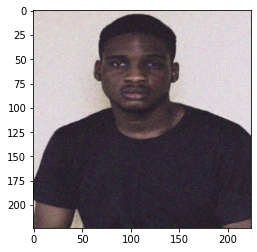

In [52]:
# img_path = '/content/drive/My Drive/SR_Data/test/lr/5_09.png'
img_path = '/content/guassian.png'
# pass the image into the image_loader function
image = image_loader(img_path)
# get prediction
predict(model, image)

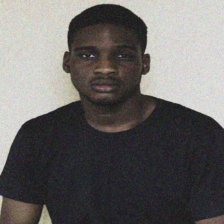

In [53]:
transforms.ToPILImage()(image.squeeze_(0))